# First attempt to the CIFAR10 image dataset

**The notebook contains results of exploring a few models each based on 20 layers, 100 units each architecture.**

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
from tensorflow.keras.datasets.cifar10 import load_data

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = load_data()

print(f'{X_train_full.shape = }')
print(f'{y_train_full.shape = }')
print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

170500096/170498071 [==============================] - 1203s 7us/step
X_train_full.shape = (50000, 32, 32, 3)
y_train_full.shape = (50000, 1)
X_test.shape = (10000, 32, 32, 3)
y_test.shape = (10000, 1)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000)

In [5]:
def plot_images(images, n_rows=5, n_cols=5, figsize=(7, 7)):
    m = len(images)
    image_shape = images.shape[1:]
    
    if m > n_cols*n_rows:
        idx = np.random.choice(m, n_rows*n_cols, replace=False)
        images = images[idx]

    q, r = divmod(m, n_cols)
    n_rows = min(n_rows, q + min(1, r))
    
    image = np.empty((n_rows*image_shape[0], n_cols*image_shape[1], image_shape[2]), dtype=images.dtype)
    for i in range(n_rows-1):
        row_image = images[i*n_cols : (i+1)*n_cols]
        np.concatenate(row_image, axis=1, out=image[image_shape[0]*i : image_shape[0]*(i+1), :, :])
    row_image = list(images[(n_rows-1)*n_cols:]) + max(0, n_rows*n_cols - m)*[np.zeros(image_shape)]
    np.concatenate(row_image, axis=1, out=image[-image_shape[0]:, :, :])
    
    if figsize:
        plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')

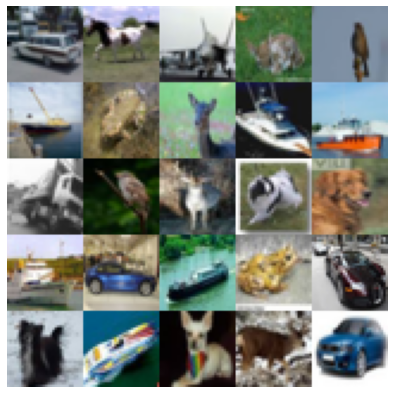

In [6]:
plot_images(X_train_full)

In [7]:
logdir = os.path.join(os.curdir, 'logs')
def get_run_logdir():
    import time
    run_id = time.strftime('%Y_%m_%d-%H_%M_%S')
    return os.path.join(logdir, run_id)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

In [9]:
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9248), started 0:00:12 ago. (Use '!kill 9248' to kill it.)

**Now let's build some model we will train.**

In [10]:
model1 = keras.models.Sequential(
    [keras.layers.Flatten(input_shape=X_train_full[0].shape)] +
    [keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal') for _ in range(20)] +
    [keras.layers.Dense(10, activation='softmax')],
    name='ELU'
)
model1.compile(optimizer=keras.optimizers.Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
model1.summary()

Model: "ELU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100   

To find proper learning rate for the model let's use simple function:

In [12]:
K = keras.backend

class LrFindSchedule(keras.callbacks.Callback):
    def __init__(self, schedule):
        super(LrFindSchedule, self).__init__()
        self.schedule = schedule
        self.losses = []
        self.rates = []
    
    def on_train_batch_begin(self, batch, logs=None):
        K.set_value(self.model.optimizer.lr, self.schedule(batch))
    
    def on_train_batch_end(self, batch, logs=None):
        self.losses.append(logs['loss'])
        self.rates.append(K.get_value(self.model.optimizer.lr))

def schedule(batch):
    return 1e-3 * np.exp(np.log(1e4)/500.0)**batch

lr_scheduler_cb = LrFindSchedule(schedule)

In [13]:
def plot_loss_lr(model, X, y, starting_lr=1e-4, max_lr=1e1, iterations=500, xlog=True, figsize=(8, 6)):
    weights = model.get_weights()
    
    def schedule(batch):
        return starting_lr * tf.math.exp(tf.math.log(max_lr/starting_lr) / iterations)**batch
    
    schedule_cb = LrFindSchedule(schedule)
    model.fit(X, y, batch_size=32, epochs=1, steps_per_epoch=iterations, verbose=0, callbacks=[schedule_cb])
    
    losses = schedule_cb.losses
    lrs = schedule_cb.rates
    
    model.set_weights(weights)
    
    plt.figure(figsize=figsize)
    plt.plot(lrs, losses)
    if xlog:
        plt.xscale('log')
    plt.ylim(np.min(losses), losses[0])
    plt.ylabel('Loss')
    plt.xlabel('Learning rate')
    plt.show()

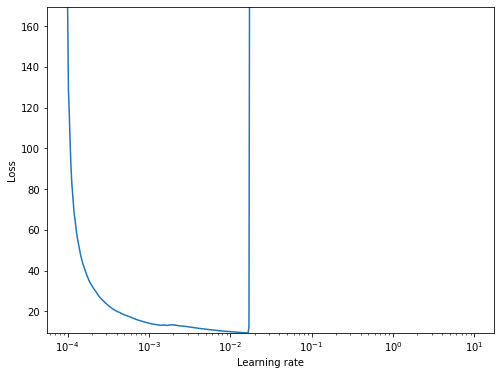

In [14]:
plot_loss_lr(model1, X_train, y_train)

So the learning rate should be less than `2e-2`. Let's try `6e-3`.

In [15]:
checkpoint_cb1 = keras.callbacks.ModelCheckpoint(os.path.join('saved_models', 'cifar10'), monitor='val_accuracy', save_best_only=True)
early_cb1 = keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
model1.compile(optimizer=keras.optimizers.Nadam(learning_rate=6e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
%%time
history1 = model1.fit(X_train, y_train, epochs=50,
                      validation_data=(X_val, y_val),
                      callbacks=[early_cb1, checkpoint_cb1, tensorboard_cb])

Epoch 1/50
1407/1407 [==============================] - 35s 25ms/step - loss: 33.4622 - accuracy: 0.1864 - val_loss: 2.3465 - val_accuracy: 0.1008
Epoch 2/50
1407/1407 [==============================] - 22s 16ms/step - loss: 2.3273 - accuracy: 0.0987 - val_loss: 2.3328 - val_accuracy: 0.0972
Epoch 3/50
1407/1407 [==============================] - 34s 24ms/step - loss: 259.1680 - accuracy: 0.1005 - val_loss: 2.3054 - val_accuracy: 0.1046
Epoch 4/50
1407/1407 [==============================] - 23s 16ms/step - loss: 2.3059 - accuracy: 0.1023 - val_loss: 2.3058 - val_accuracy: 0.1000
Epoch 5/50
1407/1407 [==============================] - 22s 16ms/step - loss: 2.3082 - accuracy: 0.0989 - val_loss: 2.3121 - val_accuracy: 0.0952
Epoch 6/50
1407/1407 [==============================] - 24s 17ms/step - loss: 2.3110 - accuracy: 0.0967 - val_loss: 2.3087 - val_accuracy: 0.1006 loss: 2.3109 - accura
Epoch 7/50
1407/1407 [==============================] - 24s 17ms/step - loss: 2.3141 - accuracy: 0.

That's not what we wished to see.

Let's try adding Batch Normalization to the model.

In [17]:
import itertools

model2 = keras.models.Sequential(
    [keras.layers.Flatten(input_shape=X_train_full[0].shape), keras.layers.BatchNormalization()] +
    list(itertools.chain.from_iterable([(keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
                                        keras.layers.BatchNormalization()) for _ in range(20)])) +
    [keras.layers.Dense(10, activation='softmax')],
    name='ELU_BN'
)
model2.compile(optimizer=keras.optimizers.Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

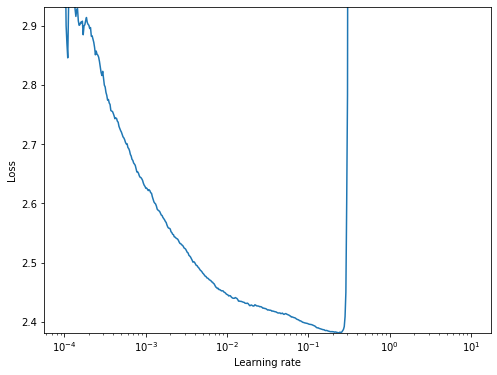

In [18]:
plot_loss_lr(model2, X_train, y_train)

In this case optimal learning rate seems to be much higher. Let's try with `7e-2`.

In [19]:
checkpoint_cb2 = keras.callbacks.ModelCheckpoint(os.path.join('saved_models', 'cifar10_v2'), monitor='val_accuracy', save_best_only=True)
early_cb2 = keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
model2.compile(optimizer=keras.optimizers.Nadam(learning_rate=7e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
%%time
history2 = model2.fit(X_train, y_train, epochs=50,
                      validation_data=(X_val, y_val),
                      callbacks=[early_cb2, checkpoint_cb2, tensorboard_cb])

Epoch 1/50
1407/1407 [==============================] - 116s 83ms/step - loss: 2.1924 - accuracy: 0.1696 - val_loss: 13.4333 - val_accuracy: 0.1576
Epoch 2/50
1407/1407 [==============================] - 37s 26ms/step - loss: 2.0951 - accuracy: 0.1750 - val_loss: 480687242210181120.0000 - val_accuracy: 0.1310
Epoch 3/50
1407/1407 [==============================] - 37s 26ms/step - loss: 2.0676 - accuracy: 0.1806 - val_loss: nan - val_accuracy: 0.1068
Epoch 4/50
1407/1407 [==============================] - 73s 52ms/step - loss: 2.0304 - accuracy: 0.1888 - val_loss: nan - val_accuracy: 0.1758
Epoch 5/50
1407/1407 [==============================] - 36s 26ms/step - loss: 2.0092 - accuracy: 0.2003 - val_loss: nan - val_accuracy: 0.1286
Epoch 6/50
1407/1407 [==============================] - 36s 26ms/step - loss: 1.9791 - accuracy: 0.2340 - val_loss: nan - val_accuracy: 0.1748
Epoch 7/50
1407/1407 [==============================] - 75s 53ms/step - loss: 1.9591 - accuracy: 0.2479 - val_loss: n

In [21]:
def plot_loss_acc(history1, history2, figsize=(8, 4)):
    loss1 = history1.history['val_loss']
    loss2 = history2.history['val_loss']
    acc1 = history1.history['val_accuracy']
    acc2 = history2.history['val_accuracy']
    loss1_label = history1.model.name + ' loss'
    loss2_label = history2.model.name + ' loss'
    acc1_label = history1.model.name + ' acc'
    acc2_label = history2.model.name + ' acc'

    fig, ax1 = plt.subplots(figsize=figsize)
    
    ax1.set_title(history1.model.name + ' and ' + history2.model.name + ' comparison',
                  size=16)
    ax1.set_xlabel('Epoch', size=14)
    ax1.set_ylabel('Val Loss', size=14)
    ax1.plot(loss1, color='red', label=loss1_label)
    ax1.plot(loss2, color='blue', label=loss2_label)
    ax1.legend(loc='right')
    plt.legend(loc=(0.75, 0.55))

    ax2 = ax1.twinx()

    ax2.set_ylabel('Val accuracy', size=14)
    ax2.plot(acc1, color='orange', label=acc1_label)
    ax2.plot(acc2, color='purple', label=acc2_label)
    plt.legend(loc=(0.75, 0.37))

    fig.tight_layout()
    plt.show()

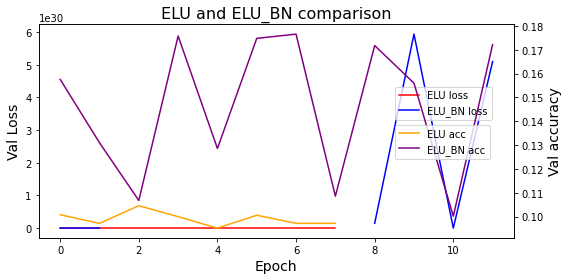

In [22]:
plot_loss_acc(history1, history2)

The second model reach much better results, however its training time is quite long.

In the next step we're going to try SELU activation function and feature scaling which should lead to self-normalizing net with even better results.

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

image_shape = X_train_full.shape[1:]
X_train_full_flat = X_train_full.reshape((X_train_full.shape[0], -1))
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_val_flat = X_val.reshape((X_val.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

scaler.fit(X_train_full_flat)

X_train_scaled = scaler.transform(X_train_flat).reshape((-1, *image_shape))
X_val_scaled = scaler.transform(X_val_flat).reshape((-1, *image_shape))
X_test_scaled = scaler.transform(X_test_flat).reshape((-1, *image_shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


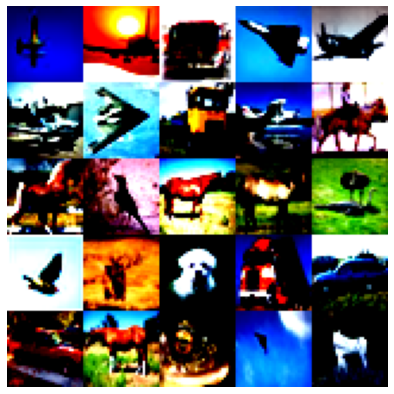

In [24]:
plot_images(X_train_scaled)

In [25]:
model3 = keras.models.Sequential(
    [keras.layers.Flatten(input_shape=X_train_full[0].shape)] +
    [keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal') for _ in range(20)] +
    [keras.layers.Dense(10, activation='softmax')],
    name='SELU'
)
model3.compile(optimizer=keras.optimizers.Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

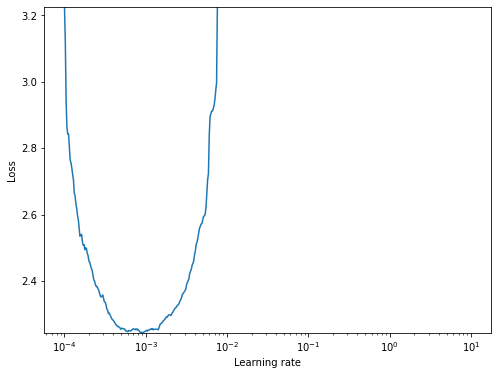

In [26]:
plot_loss_lr(model3, X_train_scaled, y_train)

Third model requires smaller learning rate, about `4e-4`.

In [27]:
checkpoint_cb3 = keras.callbacks.ModelCheckpoint(os.path.join('saved_models', 'cifar10_v3'), monitor='val_accuracy', save_best_only=True)
early_cb3 = keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
model3.compile(optimizer=keras.optimizers.Nadam(learning_rate=4e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
%%time
history3 = model3.fit(X_train_scaled, y_train, epochs=50,
                      validation_data=(X_val_scaled, y_val),
                      callbacks=[early_cb3, checkpoint_cb3, tensorboard_cb])

Epoch 1/50
1407/1407 [==============================] - 57s 41ms/step - loss: 1.8731 - accuracy: 0.3306 - val_loss: 1.7527 - val_accuracy: 0.3792
Epoch 2/50
1407/1407 [==============================] - 38s 27ms/step - loss: 1.6528 - accuracy: 0.4143 - val_loss: 1.7092 - val_accuracy: 0.4018
Epoch 3/50
1407/1407 [==============================] - 35s 25ms/step - loss: 1.5541 - accuracy: 0.4532 - val_loss: 1.6472 - val_accuracy: 0.4174
Epoch 4/50
1407/1407 [==============================] - 35s 25ms/step - loss: 1.4857 - accuracy: 0.4784 - val_loss: 1.6125 - val_accuracy: 0.4468
Epoch 5/50
1407/1407 [==============================] - 33s 23ms/step - loss: 1.4201 - accuracy: 0.4998 - val_loss: 1.5312 - val_accuracy: 0.4634
Epoch 6/50
1407/1407 [==============================] - 31s 22ms/step - loss: 1.3707 - accuracy: 0.5206 - val_loss: 1.5242 - val_accuracy: 0.4696
Epoch 7/50
1407/1407 [==============================] - 31s 22ms/step - loss: 1.3243 - accuracy: 0.5403 - val_loss: 1.5233 -

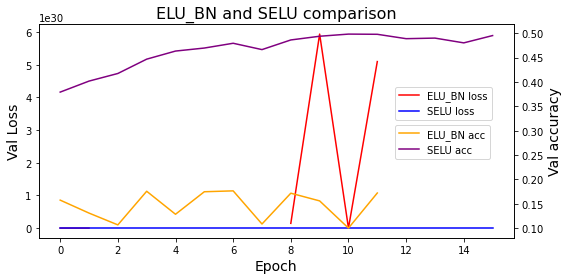

In [29]:
plot_loss_acc(history2, history3)

At last things are getting serious.

The third model performs much much better than its predecessors, but seems to overfit.

In [30]:
def plot_learning_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.plot(train_loss, color='blue', label='Train loss')
    plt.plot(val_loss, color='green', label='Val loss')
    plt.title(history.model.name + ' learning curves', size=16)
    plt.xlabel('Epoch', size=14)
    plt.ylabel('Loss', size=14)
    plt.legend(loc='right')
    plt.show()

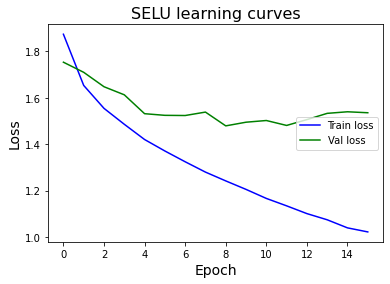

In [31]:
plot_learning_curves(history3)

Yup, it overfitted. Let's try applying some regularization with monte carlo alpha dropout and see whether we can get better.

In [32]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)


def build_mcad_model(rate, base_model=None, lr=None):
    model = keras.models.Sequential(
        [keras.layers.Flatten(input_shape=X_train_full[0].shape)] +
        [keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal') for _ in range(20)] +
        [MCAlphaDropout(rate)] + 
        [keras.layers.Dense(10, activation='softmax')],
        name='SELU_alpha_dropout'
    )
    optimizer = 'nadam'
    if lr:
        optimizer = keras.optimizers.Nadam(learning_rate=lr)
    if base_model:
        model.set_weights(base_model.get_weights())
        optimizer = base_model.optimizer
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [33]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.losses import sparse_categorical_crossentropy

def mc_dropout(model, X, y, iterations=100):
    y_probas = np.stack([model.predict(X) for _ in range(iterations)])
    y_proba = y_probas.mean(axis=0)
    y_pred = y_proba.argmax(axis=1)
    
    m = keras.metrics.SparseCategoricalCrossentropy()
    m.update_state(y, y_proba)
    
    loss = m.result().numpy()
    acc = accuracy_score(y, y_pred)
    return loss, acc

We should investigate different dropout rates to find a good one.

In [36]:
rates = np.arange(0.01, 0.22, 0.04)

m4res = []
for rate in rates:
    model4 = build_mcad_model(rate, model3)
    m4res.append((rate, mc_dropout(model4, X_val_scaled, y_val)))

m4res

[(0.01, (1.4943402, 0.4972)),
 (0.05, (1.4731289, 0.4968)),
 (0.09, (1.4635869, 0.4968)),
 (0.13, (1.460242, 0.4972)),
 (0.17, (1.4659836, 0.4972)),
 (0.21000000000000002, (1.4760152, 0.499))]

In [37]:
print('Validation results of every model:')

res = model1.evaluate(X_val, y_val, verbose=0)
print(f'{model1.name}\t\t\tloss={res[0]:.3f}\tacc={res[1]:.3f}')

res = model2.evaluate(X_val, y_val, verbose=0)
print(f'{model2.name}\t\t\tloss={res[0]:.3f}\tacc={res[1]:.3f}')

res = model3.evaluate(X_val_scaled, y_val, verbose=0)
print(f'{model3.name}\t\t\tloss={res[0]:.3f}\tacc={res[1]:.3f}')

_, res = max(m4res, key=lambda x: x[1][1])
print(f'{model4.name}\tloss={res[0]:.3f}\tacc={res[1]:.3f}')

Validation results of every model:
ELU			loss=2.305	acc=0.105
ELU_BN			loss=nan	acc=0.177
SELU			loss=1.502	acc=0.498
SELU_alpha_dropout	loss=1.476	acc=0.499


Even alpha dropout couldn't get us to significantly better results than the ELU + BN model reached.

So far we managed to produce model that overfits a bit, but let's try to reach faster training and maybe better performance with different schedule.

Last thing we're going to do is to use 1cycle scheduling on the last model looking for an improvement.

In [39]:
model5 = build_mcad_model(0.2, lr=4e-4)

def scheduler(iterations, min_lr, max_lr, top_ratio=0.8):
    top = iterations*top_ratio
    def schedule(epoch):
        if epoch < top:
            return min_lr + min(epoch, top-epoch)*(max_lr-min_lr)*2/top
        else:
            return min_lr*(1-top_ratio) + (iterations-epoch)*(min_lr*top_ratio)/iterations/(1-top_ratio)
    return schedule

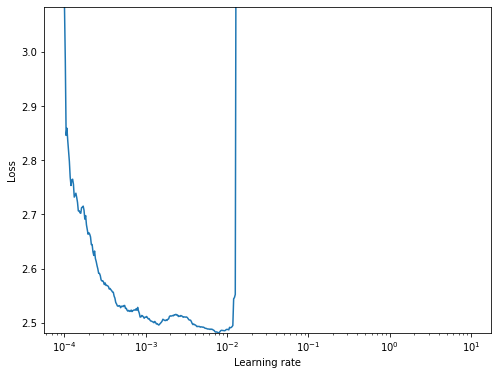

In [40]:
plot_loss_lr(model5, X_train_scaled, y_train)

In [41]:
iterations = 15
min_lr = 5e-4
max_lr = 5e-3

checkpoint_cb5 = keras.callbacks.ModelCheckpoint(os.path.join('saved_models', 'cifar10_v5'), monitor='val_accuracy', save_best_only=True)
schedule_cb5 = keras.callbacks.LearningRateScheduler(scheduler(iterations, min_lr, max_lr))

In [42]:
%%time
history5 = model5.fit(X_train_scaled, y_train, epochs=iterations,
                      validation_data=(X_val_scaled, y_val),
                      callbacks=[checkpoint_cb5, schedule_cb5, tensorboard_cb])

Epoch 1/15
1407/1407 [==============================] - 43s 31ms/step - loss: 2.1127 - accuracy: 0.2527 - val_loss: 1.9678 - val_accuracy: 0.2878
Epoch 2/15
1407/1407 [==============================] - 33s 23ms/step - loss: 1.9229 - accuracy: 0.3046 - val_loss: 1.9246 - val_accuracy: 0.3076
Epoch 3/15
1407/1407 [==============================] - 34s 24ms/step - loss: 1.8786 - accuracy: 0.3263 - val_loss: 1.9162 - val_accuracy: 0.3110
Epoch 4/15
1407/1407 [==============================] - 32s 23ms/step - loss: 1.8512 - accuracy: 0.3346 - val_loss: 1.9124 - val_accuracy: 0.3374
Epoch 5/15
1407/1407 [==============================] - 24s 17ms/step - loss: 1.8238 - accuracy: 0.3466 - val_loss: 1.8575 - val_accuracy: 0.3366
Epoch 6/15
1407/1407 [==============================] - 34s 24ms/step - loss: 1.8037 - accuracy: 0.3580 - val_loss: 1.8205 - val_accuracy: 0.3586
Epoch 7/15
1407/1407 [==============================] - 25s 17ms/step - loss: 1.7970 - accuracy: 0.3592 - val_loss: 1.8427 -

In [43]:
mc_dropout(model5, X_val_scaled, y_val, iterations=200)

(1.4996672, 0.4684)

In [46]:
mc_dropout(model5, X_test_scaled, y_test, iterations=200)

(1.4675881, 0.4814)

In [47]:
model3.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.4652 - accuracy: 0.5108


[1.4651540517807007, 0.5108000040054321]

The final model also overfits a little bit, but reaches quite good accuracy compared to last two models.

Training time is also similar so we haven't reached anything better.